In [66]:
# TF and tf.keras
import tensorflow as tf
from tensorflow import keras

from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

tf.set_random_seed(19)

print('TF Version : ', tf.__version__)
print(K.tensorflow_backend._get_available_gpus())

TF Version :  1.12.0
['/job:localhost/replica:0/task:0/device:GPU:0']


### Import the Fashion MNIST dataset

In [7]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# Img size : 28 x 28 x 1
# Num classes : 10

### Data exploration

In [9]:
print('Training data shape : ', train_images.shape)
print('Class dataset : ', train_labels.shape)
print('Testing data shape : ', test_images.shape)
print('Class dataset : ', test_labels.shape)

Training data shape :  (60000, 28, 28)
Class dataset :  (60000,)
Testing data shape :  (10000, 28, 28)
Class dataset :  (10000,)


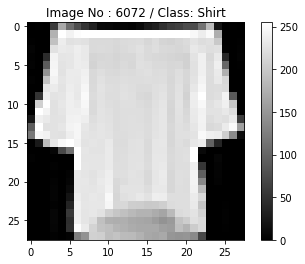

In [12]:
plt.figure()
idx = np.random.randint(0, len(train_labels))
plt.imshow(train_images[idx], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.title('Image No : %d / Class: %s' % (idx, class_names[train_labels[idx]]))
plt.show()

In [13]:
train_images = train_images / 255.0
test_images  = test_images  / 255.0

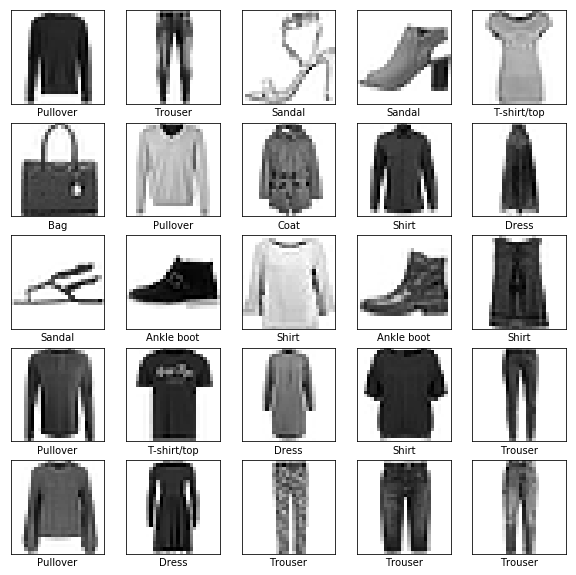

In [14]:
plt.figure(figsize=(10,10))

img_list_25 = np.random.permutation(len(train_labels))[:25]

for i, idx in enumerate(img_list_25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    plt.imshow(train_images[idx], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[idx]])
plt.show()

### Model Definition

In [70]:
# Network Topologies
n_hidden_1 = 128
n_input    = 784
n_classes  = 10

class Model:
    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        self.Layers()
    
    # Build model
    def Layers(self):
        with tf.variable_scope(self.name):
            # Set Inputs and Outputs
            self.X = tf.placeholder(tf.float32, shape=[None, n_input], name='X')
            self.Y = tf.placeholder(tf.float32, shape=[None, n_classes], name='Y')
            
            # Set Layers
            L1 = tf.layers.Dense(units=n_hidden_1)(self.X)
            L1 = tf.nn.relu(L1)
            
            pred = tf.layers.Dense(units=n_classes)(L1)
        
        # Loss and Optimizers
        self.cost = tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=self.Y)
        self.cost = tf.reduce_mean(self.cost)

        self.optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.cost)

        corr = tf.equal(tf.argmax(pred, 1), tf.argmax(self.Y, 1))
        accr = tf.reduce_mean(tf.cast(corr, tf.float32))
        
    
    def train(self, x_data, y_data):
        self.sess.run([self.cost, self.optm], 
                      feed_dict={self.X:x_data, self.Y:y_data})
    

In [15]:
# Network Topologies
n_hidden_1 = 128
n_input    = 784
n_classes  = 10

# Inputs and Outputs
x = tf.placeholder(tf.float32, shape=[None, n_input], name='X')
y = tf.placeholder(tf.float32, shape=[None, n_classes], name='Y')

#NETWORK PARAMETERS
stddev = 0.1
weights = {
    'h1' : tf.Variable(tf.random_normal(shape=[n_input,    n_hidden_1], stddev=stddev)),
    'out': tf.Variable(tf.random_normal(shape=[n_hidden_1, n_classes],  stddev=stddev))
}

bias = {
    'b1' : tf.Variable(tf.random_normal(shape=[n_hidden_1])),
    'out': tf.Variable(tf.random_normal(shape=[n_classes]))
}

print('Model definition completed') # Check the grammar error above


Model definition completed


### MLP as a function

In [16]:
def MLP(X_, weights_, bias_):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(X_, weights_['h1']), bias_['b1']))
    out     = tf.add(tf.matmul(layer_1, weights_['out']), bias_['out'])
    return out

### Create Tensor graph for ANN

In [64]:
# Prediction
pred = MLP(x, weights, bias)

# Loss and Optimizer
# Do calculate C/E with logits.. not with softmax values
cost = tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y)
cost = tf.reduce_mean(cost)

#cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(tf.nn.softmax(pred) + 0.1), reduction_indices=1))

optm = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

corr = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accr = tf.reduce_mean(tf.cast(corr, tf.float32))

# Initializer
init = tf.global_variables_initializer()

print('Tensor graph completed')

# Session
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())

Tensor graph completed


In [52]:
N_CLS = 10
N_TRN = len(train_labels)
N_TST = len(test_labels)

train_labels_1h = sess.run(tf.one_hot(train_labels, depth=10))
test_labels_1h  = sess.run(tf.one_hot(test_labels, depth=10))

train_images_flat = sess.run(tf.reshape(train_images, shape=(N_TRN,-1)))
test_images_flat  = sess.run(tf.reshape(test_images, shape=(N_TST,-1)))

print(train_images_flat.shape)
print(test_labels_1h.shape)


(60000, 784)
(10000, 10)


### Fit the model

In [65]:
training_epochs = 20
batch_size      = 32
display_step    = 5

# Minibatch learning
for epoch in range(training_epochs): # Epochs
    avg_cost = 0.0
    num_batch = int(N_TRN / batch_size)
    
    # Get random minibatch for each epoch
    randindices = np.random.permutation(len(train_labels_1h))
    
    for i in range(num_batch):
        cur_indices = randindices[i*batch_size:(i+1)*batch_size]
    
        batch_xs = train_images_flat[cur_indices, :]
        batch_ys = train_labels_1h[cur_indices, :]
    
        feeds = {x:batch_xs, y:batch_ys}
    
        sess.run(optm, feed_dict=feeds)
        avg_cost += sess.run(cost, feed_dict=feeds) / num_batch
    
    # Display training steps
    if epoch % display_step == 0:
        feeds_train = {x: batch_xs, y: batch_ys}
        feeds_test  = {x: test_images_flat, y:test_labels_1h}
        
        train_acc = sess.run(accr, feed_dict=feeds_train)
        test_acc  = sess.run(accr, feed_dict=feeds_test)
        
        print('Epoch: %03d/%03d cost: %0.9f train_acc: %.3f test_acc %.3f'
              % (epoch, training_epochs, avg_cost, train_acc, test_acc))
print('Done')

Epoch: 000/050 cost: 0.759111286 train_acc: 0.844 test_acc 0.807
Epoch: 005/050 cost: 0.380487976 train_acc: 0.938 test_acc 0.854
Epoch: 010/050 cost: 0.332007035 train_acc: 0.875 test_acc 0.863
Epoch: 015/050 cost: 0.301335501 train_acc: 0.938 test_acc 0.873
Epoch: 020/050 cost: 0.279438510 train_acc: 0.969 test_acc 0.873
Epoch: 025/050 cost: 0.261829078 train_acc: 0.938 test_acc 0.875
Epoch: 030/050 cost: 0.246637811 train_acc: 0.812 test_acc 0.878


KeyboardInterrupt: 